<a href="https://colab.research.google.com/github/AlvinScrp/LLMs-from-scratch-CN/blob/main/finetuning-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 进行文本分类的微调

```python
import os
from huggingface_hub import login
os.environ["HF_TOKEN"] = "hf_any"
login(token=os.environ["HF_TOKEN"])

#校验是否设置成功
! echo $HF_TOKEN
```

In [ ]:
##屏蔽进度条，github中不支持显示，整个notebook都不显示了
import os
# 设置这个环境变量来禁用tqdm进度条
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

import datasets
datasets.disable_progress_bar()

## huggingface gpt2
使用[huggingface gpt2](https://huggingface.co/openai-community/gpt2)

为了理解 huggingface gpt2的使用，写一个文本生成示例代码，感受下

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
print(model.config)
print('*'*10)
print(output.last_hidden_state.shape)
print(model.wte.weight.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.57.1",
  "use_cache": true,
  "vocab_size": 50257
}

**********
torch.Size([1, 10, 768])
torch.Size([50257, 768])


### 自定生成文本Model

In [ ]:
import torch
from torch import nn
from transformers import GPT2Tokenizer, GPT2Model
class MyGPT2LMHeadModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.gpt2 = GPT2Model.from_pretrained('gpt2')
    config = self.gpt2.config
    self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
    self.lm_head.weight = self.gpt2.wte.weight

  def forward(self,in_idx):
    gpt2_out = self.gpt2(in_idx)
    logits = self.lm_head(gpt2_out.last_hidden_state)
    return logits

def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]/temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx




In [ ]:
prompt_text = "In a cozy little cottage, lived a fluffy cat named Whiskers. One sunny morning,"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")
myGPT2LMHeadModel = MyGPT2LMHeadModel()
myGPT2LMHeadModel.to(device)
token_ids = generate(
    model=myGPT2LMHeadModel,
    idx= tokenizer.encode(prompt_text, return_tensors='pt').to(device),
    max_new_tokens=50,
    context_size=1024,
    top_k=50,
    temperature=0.9
)

print("Output text:\n", tokenizer.decode(token_ids[0], skip_special_tokens=True))

使用的设备: cuda
Output text:
 In a cozy little cottage, lived a fluffy cat named Whiskers. One sunny morning, he and his cat, Kitten, had a hard time sleeping. Their cat, a baby kitten, could not wake up but was fine after a night of fun and play. Soon afterward, Kitten's parents were back at home with him,


### 使用transformers的GPT2LMHeadModel生成文本

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 检查是否有可用的 GPU，并设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")

# 1. 加载带有语言模型头的模型和分词器
# 将模型移动到指定的设备上
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
modelLMHead = GPT2LMHeadModel.from_pretrained('gpt2')
modelLMHead.to(device)

input_ids = tokenizer.encode(prompt_text, return_tensors='pt').to(device)

# 4. 使用 model.generate() 生成文本
print("\n正在生成故事...")
# 调用 generate 方法来创作故事
output_sequences = modelLMHead.generate(
    input_ids=input_ids,
    max_length=50,          # 生成文本的最大长度（包含提示）
    num_return_sequences=1,  # 生成几个不同的故事
    no_repeat_ngram_size=2,  # 避免重复短语的关键参数
    do_sample=True,          # 启用采样，让文本更有创意，而不是死板的预测
    temperature=0.9,         # 控制创造性与确定性的平衡，数值越低越保守
    top_k=50,                # 采样时只考虑概率最高的50个词
    top_p=0.95,              # 核心采样，保留概率总和为95%的词汇
)

# 5. 解码生成的文本
# 将生成的数字ID序列转换回人类可读的字符串
generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

# 6. 打印结果
print("\n--- 生成的故事 ---")
print(generated_text)


使用的设备: cuda


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



正在生成故事...

--- 生成的故事 ---
In a cozy little cottage, lived a fluffy cat named Whiskers. One sunny morning, Whizzers noticed Whiskey's fluffy coat. He and Whisky walked to the cottage and found Whistle sleeping in Whisp, a small room


## finetuning-for-classification

- 如果您具有机器学习的背景，对于分类微调您可能已经熟悉. 举个例子，分类微调类似于训练卷积网络来对手写数字进行分类的过程
- 在分类微调中，模型可以输出特定的分类标签（例如，“spam”和“not spam”）
- 分类微调模型只能预测它在训练期间所熟知的类别标签（例如，“垃圾邮件”或“非垃圾邮件”），而指令微调模型通常可以执行更广泛的任务
- 我们可以将分类微调模型视为高度专业化的模型;在实践中，开发专业化的模型通常比开发在许多不同任务上表现良好的通用模型要容易得多

###准备数据集
我们使用由垃圾邮件和非垃圾邮件组成的数据集来对 LLM 进行分类微调

In [ ]:
import os
import torch
import pandas as pd
import urllib.request
import zipfile
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from datasets import Dataset, DatasetDict

# === 1. 全局配置 ===
URL = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
ZIP_PATH = "sms_spam_collection.zip"
DATA_DIR = Path("sms_spam_collection")
DATA_FILE = DATA_DIR / "SMSSpamCollection.tsv"
BATCH_SIZE = 8
RANDOM_STATE = 123
NUM_WORKERS = 2


# === 2. 数据准备 ===
def prepare_data():
    if not DATA_FILE.exists():
        print("⬇️ Downloading and extracting dataset...")
        with urllib.request.urlopen(URL) as r, open(ZIP_PATH, "wb") as f:
            f.write(r.read())
        with zipfile.ZipFile(ZIP_PATH, "r") as z:
            z.extractall(DATA_DIR)
        os.rename(DATA_DIR / "SMSSpamCollection", DATA_FILE)
    else:
        print("✅ Dataset already exists.")

    df = pd.read_csv(DATA_FILE, sep="\t", names=["Label", "Text"])
    print(f"Loaded {len(df)} samples")
    print(df["Label"].value_counts())

    # 平衡数据集，ham:4825 ,spam:747， 使每个类别包含 747 个实例。
    ham = df[df["Label"] == "ham"].sample(n=df.Label.value_counts()["spam"], random_state=RANDOM_STATE)
    df = pd.concat([ham, df[df["Label"] == "spam"]])
    df["Label"] = df["Label"].map({"ham": 0, "spam": 1})
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    n = len(df)
    return df[:int(0.7*n)], df[int(0.7*n):int(0.8*n)], df[int(0.8*n):]


# === 3. Tokenizer & Dataset 使用 Hugging Face `datasets` 库 ===
def build_datasetDict(train_df, val_df, test_df):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    datasetDict = DatasetDict({
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df)
    })

    print("\n🔢 Calculating max sequence length (may take a few seconds)...")
    train_texts = datasetDict["train"]["Text"]

    custom_format = "{desc}: {percentage:3.0f}% | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]"
    max_len = max(len(tokenizer.encode(t)) for t in tqdm(train_texts,bar_format=custom_format))
    print(f"Max length: {max_len}")

    def tokenize_fn(batch):
        return tokenizer(batch["Text"], truncation=True, padding="max_length", max_length=max_len)

    print("\n✂️ Tokenizing datasets...")
    tokenized = datasetDict.map(tokenize_fn, batched=True, remove_columns=["Text"])
    tokenized = tokenized.rename_column("Label", "labels")
    tokenized.set_format(type="torch", columns=[ "input_ids", "attention_mask","labels"])
    return tokenized


# === 4. DataLoader ===
def create_loaders(datasetDict):
    return {
        split: DataLoader(ds, batch_size=BATCH_SIZE,  shuffle=(split == "train"),num_workers=NUM_WORKERS)
        for split, ds in datasetDict.items()
    }


# === 主流程 ===
print("🏗 Preparing data...")
train_df, val_df, test_df = prepare_data()
datasetDict = build_datasetDict(train_df, val_df, test_df)
loaders = create_loaders(datasetDict)

train_loader, val_loader, test_loader = loaders["train"], loaders["validation"], loaders["test"]

print("\n✅ Data pipeline ready!")
for name, loader in loaders.items():
    print(f"{name:>10}: {len(loader)} batches")

# === 示例输出 ===
print("\n📦 Example batch from train_loader:")
batch = next(iter(loaders["train"]))
for k, v in batch.items():
    print(f"{k:>15}:", v.shape)

# 查看实际文本
print("\n📝 Decoded sample text:")
sample_ids = batch["input_ids"][0]
decoded = GPT2Tokenizer.from_pretrained("gpt2").decode(sample_ids, skip_special_tokens=True)
print(decoded)
print("Label:", batch["labels"][0].item())


🏗 Preparing data...
⬇️ Downloading and extracting dataset...
Loaded 5572 samples
Label
ham     4825
spam     747
Name: count, dtype: int64

🔢 Calculating max sequence length (may take a few seconds)...


100% | 1045/1045 [00:00<00:00, 2412.67it/s]


Max length: 120

✂️ Tokenizing datasets...

✅ Data pipeline ready!
     train: 131 batches
validation: 19 batches
      test: 38 batches

📦 Example batch from train_loader:
         labels: torch.Size([8])
      input_ids: torch.Size([8, 120])
 attention_mask: torch.Size([8, 120])

📝 Decoded sample text:
As a valued customer, I am pleased to advise you that following recent review of your Mob No. you are awarded with a £1500 Bonus Prize, call 09066364589
Label: 1


In [ ]:
batch["input_ids"].shape

torch.Size([8, 120])

## 模型

In [ ]:
import torch
from torch import nn
from transformers import GPT2Tokenizer, GPT2Model
class GPT2ClassificationModel(nn.Module):
  def __init__(self,num_labels = 2):
    super().__init__()
    self.gpt2 = GPT2Model.from_pretrained('gpt2')
    config = self.gpt2.config
    self.classifier = nn.Linear(config.hidden_size, num_labels, bias=True)

  def forward(self,input_ids,attention_mask):
    gpt2_out = self.gpt2(input_ids,attention_mask=attention_mask)
    logits = self.classifier(gpt2_out.last_hidden_state[:, -1, :])
    return logits

## 训练与验证

In [31]:
import time
class GPT2ClassificationModel(nn.Module):
  def __init__(self,num_labels = 2):
    super().__init__()
    self.gpt2 = GPT2Model.from_pretrained('gpt2')
    config = self.gpt2.config
    self.classifier = nn.Linear(config.hidden_size, num_labels, bias=True)

  def forward(self,input_ids,attention_mask):
    gpt2_out = self.gpt2(input_ids,attention_mask=attention_mask)
    logits = self.classifier(gpt2_out.last_hidden_state[:, -1, :])
    return logits

def train(model, train_loader,val_loader, optimizer,loss_fn, lr_scheduler, device):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        progress_bar = tqdm(train_loader,
                            desc=f"Epoch {epoch+1}/{num_epochs}",
                            bar_format="{desc}: {n_fmt}/{total_fmt} {postfix}")

        total_train_loss = 0  # 初始化总损失
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"])
            loss = loss_fn(outputs, batch["labels"])
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
            cost = time.time() - start_time
            progress_bar.set_postfix({"Cost": f"{cost:.2f}s"})

        # 3. 评估循环
        model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0  # 初始化总损失

        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                logits = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"])
                loss = loss_fn(logits, batch["labels"])
                total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            total_correct += (predictions == batch["labels"]).sum().item()
            total_samples += len(batch["labels"])

        # 计算平均损失和准确率
        avg_val_loss = total_loss / len(val_loader)
        accuracy = total_correct / total_samples

        avg_train_loss = total_train_loss / len(train_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(accuracy)

        # tqdm.write 不会破坏进度条的单行显示
        tqdm.write(
            f"Epoch {epoch+1}/{num_epochs}.                | "
            f"TrainLoss={avg_train_loss:.4f} | "
            f"ValLoss={avg_val_loss:.4f} | "
            f"Acc={accuracy:.4f}")

    return history

from torch.optim import AdamW
from transformers import get_scheduler
import torch
from tqdm import tqdm

# 1. 初始化模型、优化器、损失函数
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = GPT2ClassificationModel(num_labels=2)
model.to(device)

# --- 支持：冻结 GPT2 模型的参数，或者只训练某几层 ---
# for param in model.gpt2.parameters():
#     param.requires_grad = False
# ------------------------------------

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# 2. 训练循环
history = train(
    model = model,
    train_loader=train_loader ,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    device=device
)


Epoch 1/3: 131/131 , Cost=27.45s


Epoch 1/3.                | TrainLoss=0.1834 | ValLoss=0.0249 | Acc=0.9800


Epoch 2/3: 131/131 , Cost=27.11s


Epoch 2/3.                | TrainLoss=0.0428 | ValLoss=0.0367 | Acc=0.9867


Epoch 3/3: 131/131 , Cost=26.74s


Epoch 3/3.                | TrainLoss=0.0140 | ValLoss=0.0488 | Acc=0.9867


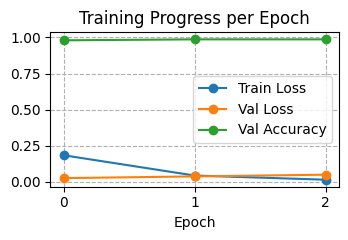

In [41]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(history["train_loss"]))  # [0, 1, 2, ...]

plt.figure(figsize=(3.5, 2.5))

# 三条曲线
plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="tab:blue")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o", color="tab:orange")
plt.plot(epochs, history["val_acc"], label="Val Accuracy", marker="o", color="tab:green")

# 图表美化
plt.title("Training Progress per Epoch")
plt.xlabel("Epoch")
plt.xticks(epochs)  # x 轴从 0 开始为整数
plt.grid(True, linestyle="--", alpha=1)
plt.legend()
plt.tight_layout()
plt.show()

##预测
